# 1 Data Simulation

In [44]:
import numpy as np
from numpy.random import randint
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

In [45]:
class SimulateTrial:
    '''Generate physiological signals for 1 trial'''
    
    duration = 10 # s
    sampling_rate = 50
    cut_off = duration * sampling_rate
    
    def __init__(
        self,
        # with default physiological profile for 1 subject
        ramp_up = {
            "heart_rate" : 70,
            "heart_rate_std" : 2,
            "respiratory_rate" : 15,
            "drift" : 0.01
        },
        ramp_off = {
            "heart_rate" : 65,
            "heart_rate_std" : 5,
            "respiratory_rate" : 12,
            "drift" : -0.01
        }):
        self.ramp_up = ramp_up
        self.ramp_off = ramp_off

    # simulate physiological signals using nk2
    def signals(
        self,
        sampling_rate=sampling_rate,
        duration=duration):
        
        ecg = [
            *nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, noise=0.1,
                heart_rate=self.ramp_up["heart_rate"], 
                heart_rate_std=self.ramp_up["heart_rate_std"]),
            *nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, noise=0.1,
                heart_rate=self.ramp_off["heart_rate"], 
                heart_rate_std=self.ramp_off["heart_rate_std"])
        ]
        rsp = [
            *nk.rsp_simulate(duration=duration, sampling_rate=sampling_rate,
                respiratory_rate=self.ramp_up["respiratory_rate"]),
            *nk.rsp_simulate(duration=duration, sampling_rate=sampling_rate,
                respiratory_rate=self.ramp_off["respiratory_rate"])
        ]
        scl = [
            *nk.eda_process(
                nk.eda_simulate(
                    duration=duration, sampling_rate=sampling_rate, noise=0.1,
                    scr_number=2, drift=self.ramp_up["drift"]),
                sampling_rate=sampling_rate)[0]["EDA_Tonic"],
            *nk.eda_process(
                nk.eda_simulate(
                    duration=duration, sampling_rate=sampling_rate, noise=0.1,
                    scr_number=2, drift=self.ramp_off["drift"]),
                sampling_rate=sampling_rate)[0]["EDA_Tonic"]
        ]
        
        data = np.stack([ecg,rsp,scl],axis=1)
        
        return data
    

In [46]:
class SimulateSubject:
    '''Generate a physiological profile for 1 subject'''

    def __init__(self, seed):
        # 1 seed for 1 subject
        self.seed = seed
        self.ramp_up, self.ramp_off = self.physio()

    def physio(self):

        np.random.seed(self.seed)

        ramp_up = {
            "heart_rate": randint(68, 70),
            "heart_rate_std": randint(2, 3),
            "respiratory_rate": randint(14, 15),
            "drift": randint(0, 1)/100
        }
        ramp_off = {
            "heart_rate": randint(65, 67),
            "heart_rate_std": randint(4, 5),
            "respiratory_rate": randint(12, 13),
            "drift": -randint(0, 1)/100
        }

        return ramp_up, ramp_off


In [47]:
class SimulateExperiment(SimulateSubject,SimulateTrial):
    '''Generate experimental data over several trials using 
    different physiological profiles'''
    def __init__(
        self,
        n_subjects=4,
        n_trials=3):
        
        self.n_subjects = n_subjects
        self.n_trials = n_trials

        self.data = self.simulate()

    def simulate(self):
        data = []
        
        for i in range(self.n_subjects):
            ramp_up = SimulateSubject(i).ramp_up
            ramp_off = SimulateSubject(i).ramp_off
            data_subject = []

            for j in range(self.n_trials):
                temp = SimulateTrial(ramp_up=ramp_up,
                                     ramp_off=ramp_off).signals()
                data_subject.append(temp)

            data.append(data_subject)

        data = np.array(data)

        return data
        

In [48]:
data = SimulateExperiment(n_subjects=10,n_trials=20).data
data.shape

(10, 20, 1000, 3)

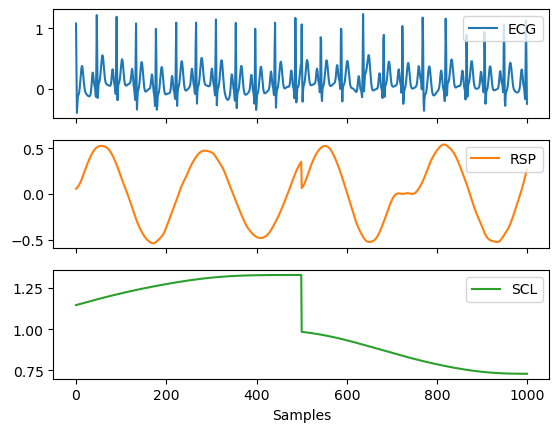

In [ ]:
# Visualise 1 trial
subject = 2
trial = 2
data_plot = pd.DataFrame({
            "ECG": data[subject,trial,:,0],
            "RSP": data[subject,trial,:,1],
            "SCL": data[subject,trial,:,2]})

nk.signal_plot(data_plot, subplots=True)

In [50]:
# Save data
np.save("data\data.npy", data)

# 2 Baseline Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# Load data
data = np.load("data\data.npy")
data.shape

(10, 20, 1000, 3)

ValueError: Found array with dim 4. StandardScaler expected <= 2.